# Determining Review Informativeness

This notebook explores various methods to determine if a review is informative or not. We'll analyze Yelp reviews using multiple approaches including:

1. **Length and Detail Analysis**
2. **Specificity Metrics**
3. **Content Quality Indicators**
4. **Machine Learning Approaches**
5. **Semantic Analysis**

## What Makes a Review Informative?

An informative review typically:
- Provides specific details about the experience
- Mentions concrete aspects (service, food quality, atmosphere, etc.)
- Uses descriptive language rather than just emotional reactions
- Offers actionable insights for future customers
- Has reasonable length (not too short, not excessively long)

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from textstat import flesch_reading_ease, flesch_kincaid_grade
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Load the Yelp review dataset
print("Loading Yelp review data...")

# Load test data (smaller file for demonstration)
test_df = pd.read_csv('dataset/test.csv')

# Sample a subset for demonstration (first 1000 reviews)
df = test_df.head(1000).copy()

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few reviews:")
print(df.head(3))

Loading Yelp review data...
Dataset shape: (1000, 2)
Columns: ['class_index', 'review_text']

First few reviews:
   class_index                                        review_text
0            2  Contrary to other reviews, I have zero complai...
1            1  Last summer I had an appointment to get new ti...
2            2  Friendly staff, same starbucks fair you get an...
Dataset shape: (1000, 2)
Columns: ['class_index', 'review_text']

First few reviews:
   class_index                                        review_text
0            2  Contrary to other reviews, I have zero complai...
1            1  Last summer I had an appointment to get new ti...
2            2  Friendly staff, same starbucks fair you get an...


In [22]:
# Text preprocessing functions
def clean_text(text):
    """Clean and normalize text for analysis"""
    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text.strip())
    # Replace escaped newlines
    text = text.replace('\\n', ' ')
    return text

def extract_basic_features(text):
    """Extract basic text features"""
    cleaned_text = clean_text(text)
    
    # Basic counts
    char_count = len(cleaned_text)
    word_count = len(cleaned_text.split())
    sentence_count = len(sent_tokenize(cleaned_text))
    
    # Average word length
    words = cleaned_text.split()
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    
    # Average sentence length
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
    
    return {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length
    }

# Apply text cleaning
df['cleaned_text'] = df['review_text'].apply(clean_text)

# Extract basic features
basic_features = df['cleaned_text'].apply(extract_basic_features)
basic_features_df = pd.DataFrame(basic_features.tolist())

# Combine with original dataframe
df = pd.concat([df, basic_features_df], axis=1)

print("Text preprocessing completed!")
print(f"Sample features for first review:")
print(basic_features_df.head(1))

Text preprocessing completed!
Sample features for first review:
   char_count  word_count  sentence_count  avg_word_length  \
0         677         126               7         4.380952   

   avg_sentence_length  
0                 18.0  


## Method 1: Length and Detail Analysis

The first approach to determine informativeness is based on the assumption that more informative reviews tend to have:
- Moderate to longer length (but not excessively long)
- Multiple sentences
- Reasonable word complexity
- Good readability scores

Length Analysis Results:
Reviews classified as informative (length): 945/1000 (94.5%)
Average length score: 0.857


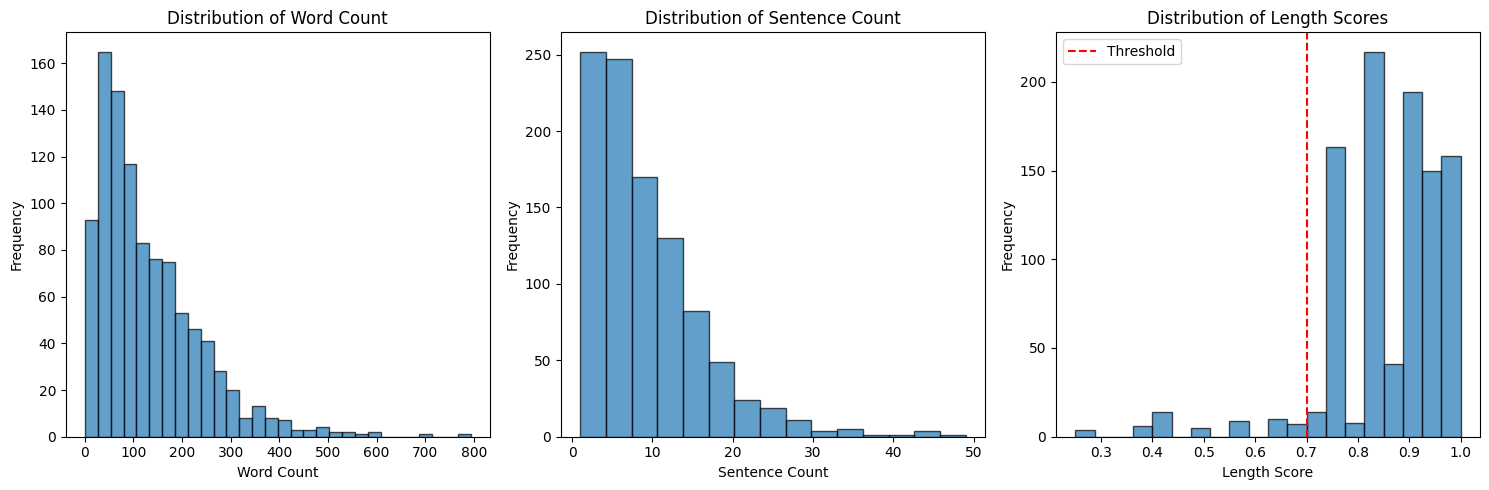

In [23]:
# Method 1: Length and Detail Analysis

def calculate_length_score(row):
    """Calculate informativeness score based on length metrics"""
    word_count = row['word_count']
    sentence_count = row['sentence_count']
    avg_sentence_length = row['avg_sentence_length']
    
    # Score based on word count (optimal range: 20-200 words)
    if word_count < 10:
        word_score = 0.1  # Too short
    elif word_count <= 30:
        word_score = 0.6  # Short but might be informative
    elif word_count <= 100:
        word_score = 1.0  # Good length
    elif word_count <= 200:
        word_score = 0.9  # Longer, still good
    else:
        word_score = 0.7  # Very long, might be rambling
    
    # Score based on sentence count (more sentences = more structure)
    if sentence_count <= 1:
        sentence_score = 0.3
    elif sentence_count <= 3:
        sentence_score = 0.7
    elif sentence_count <= 6:
        sentence_score = 1.0
    else:
        sentence_score = 0.8
    
    # Score based on sentence complexity (average words per sentence)
    if avg_sentence_length < 5:
        complexity_score = 0.4  # Too simple
    elif avg_sentence_length <= 15:
        complexity_score = 1.0  # Good complexity
    elif avg_sentence_length <= 25:
        complexity_score = 0.8  # Moderate complexity
    else:
        complexity_score = 0.6  # Might be too complex
    
    # Combined score
    length_score = (word_score * 0.4 + sentence_score * 0.3 + complexity_score * 0.3)
    return length_score

# Calculate length scores
df['length_score'] = df.apply(calculate_length_score, axis=1)

# Classify reviews based on length score
df['length_informative'] = df['length_score'] >= 0.7

print("Length Analysis Results:")
print(f"Reviews classified as informative (length): {df['length_informative'].sum()}/{len(df)} ({df['length_informative'].mean():.1%})")
print(f"Average length score: {df['length_score'].mean():.3f}")

# Visualize length distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['word_count'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')

plt.subplot(1, 3, 2)
plt.hist(df['sentence_count'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Count')

plt.subplot(1, 3, 3)
plt.hist(df['length_score'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Length Score')
plt.ylabel('Frequency')
plt.title('Distribution of Length Scores')
plt.axvline(x=0.7, color='red', linestyle='--', label='Threshold')
plt.legend()

plt.tight_layout()
plt.show()

## Method 2: Specificity Analysis

Informative reviews typically contain specific details rather than just general statements. We'll analyze:
- Presence of specific business aspects (food, service, atmosphere, etc.)
- Use of descriptive adjectives
- Mention of concrete details (prices, times, specific items)
- Presence of comparative language

Specificity Analysis Results:
Reviews classified as informative (specificity): 482/1000 (48.2%)
Average specificity score: 0.488

Average component scores:
Aspect mentions: 0.565
Descriptive language: 0.308
Specific details: 0.599
Comparisons: 0.353


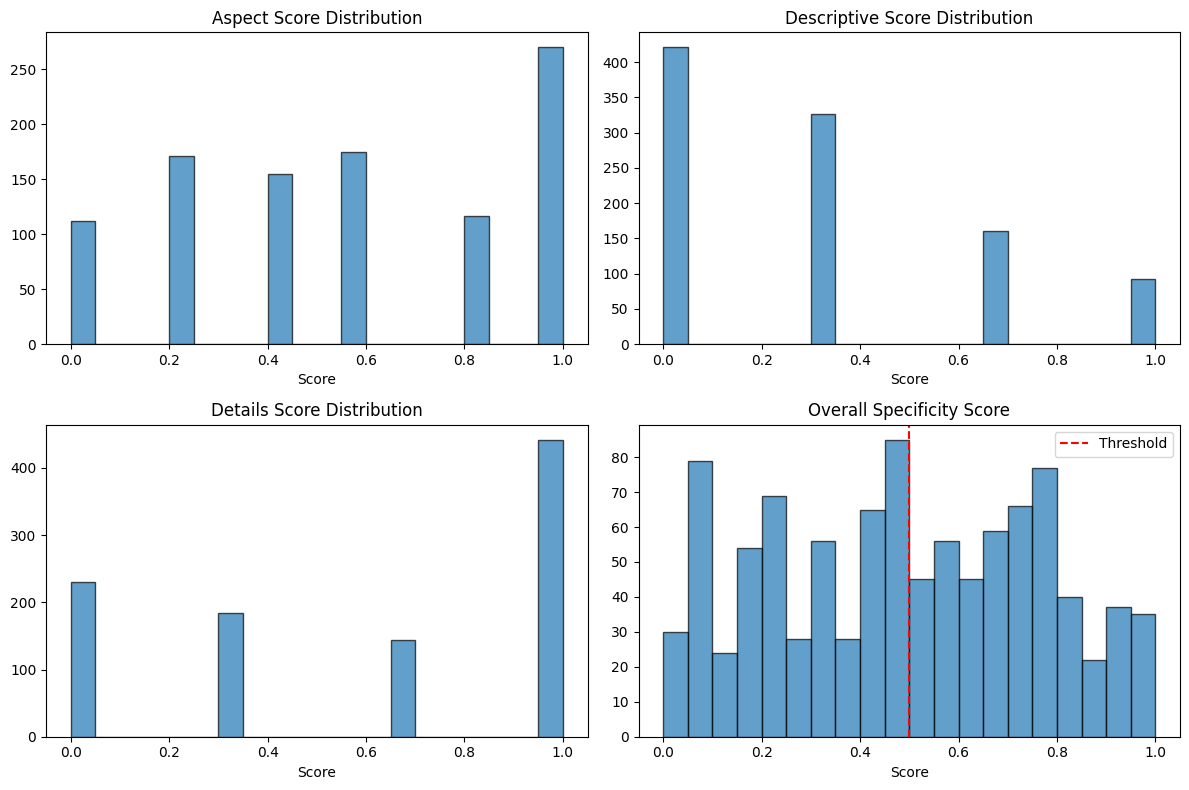

In [24]:
# Method 2: Specificity Analysis

def calculate_specificity_score(text):
    """Calculate informativeness score based on specificity indicators"""
    text_lower = text.lower()
    
    # Business aspects keywords
    # Generalized aspect keywords for various business types
    service_words = [
        'service', 'staff', 'employee', 'manager', 'customer service', 'support', 'representative', 'clerk', 'cashier'
    ]
    product_words = [
        'product', 'item', 'selection', 'quality', 'variety', 'availability', 'stock', 'goods', 'merchandise'
    ]
    experience_words = [
        'experience', 'visit', 'appointment', 'session', 'event', 'activity', 'class', 'tour', 'trip'
    ]
    environment_words = [
        'environment', 'atmosphere', 'ambiance', 'clean', 'comfortable', 'space', 'location', 'facility', 'store', 'office', 'building'
    ]
    price_words = [
        'price', 'cost', 'expensive', 'cheap', 'value', 'money', 'dollar', '$', 'budget', 'fee', 'rate', 'charge'
    ]
    time_words = [
        'wait', 'time', 'quick', 'slow', 'minutes', 'hours', 'fast', 'prompt', 'delay', 'schedule', 'appointment'
    ]
    
    all_aspect_words = (
        service_words + product_words + experience_words +
        environment_words + price_words + time_words
    )
    
    # Count aspect mentions
    aspect_mentions = sum(1 for word in all_aspect_words if word in text_lower)
    aspect_score = min(aspect_mentions / 5, 1.0)  # Normalize to max 1.0
    
    # Descriptive adjectives (more descriptive = more informative)
    descriptive_words = [
        'excellent', 'terrible', 'amazing', 'awful', 'outstanding', 'horrible', 'fantastic', 'disappointing',
        'perfect', 'worst', 'best', 'incredible', 'friendly', 'rude', 'helpful', 'unprofessional', 'attentive',
        'slow', 'quick', 'clean', 'dirty', 'comfortable', 'uncomfortable', 'professional', 'efficient', 'knowledgeable'
    ]
    
    descriptive_count = sum(1 for word in descriptive_words if word in text_lower)
    descriptive_score = min(descriptive_count / 3, 1.0)
    
    # Specific details indicators
    numbers = len(re.findall(r'\b\d+\b', text))  # Numbers (prices, times, quantities)
    specific_places = len(re.findall(
        r'\b(table|booth|bar|counter|window|parking|bathroom|desk|room|section|area|floor|entrance|exit|checkout|register)\b',
        text_lower))
    specific_items = len(re.findall(
        r'\b(burger|pizza|salad|sandwich|coffee|beer|wine|steak|product|item|service|package|deal|offer|appointment|class|session|ticket|order)\b',
        text_lower))
    
    details_score = min((numbers + specific_places + specific_items) / 3, 1.0)
    
    # Comparison indicators (shows thoughtful analysis)
    comparison_words = ['better', 'worse', 'compared', 'than', 'like', 'similar', 'different', 'previous']
    comparison_count = sum(1 for word in comparison_words if word in text_lower)
    comparison_score = min(comparison_count / 2, 1.0)
    
    # Combined specificity score
    specificity_score = (aspect_score * 0.4 + descriptive_score * 0.25 + 
                        details_score * 0.25 + comparison_score * 0.1)
    
    return {
        'aspect_score': aspect_score,
        'descriptive_score': descriptive_score,
        'details_score': details_score,
        'comparison_score': comparison_score,
        'specificity_score': specificity_score
    }

# Calculate specificity scores
specificity_features = df['cleaned_text'].apply(calculate_specificity_score)
specificity_df = pd.DataFrame(specificity_features.tolist())

# Add to main dataframe
df = pd.concat([df, specificity_df], axis=1)

# Classify reviews based on specificity score
df['specificity_informative'] = df['specificity_score'] >= 0.5

print("Specificity Analysis Results:")
print(f"Reviews classified as informative (specificity): {df['specificity_informative'].sum()}/{len(df)} ({df['specificity_informative'].mean():.1%})")
print(f"Average specificity score: {df['specificity_score'].mean():.3f}")

# Show score breakdown
print("\nAverage component scores:")
print(f"Aspect mentions: {df['aspect_score'].mean():.3f}")
print(f"Descriptive language: {df['descriptive_score'].mean():.3f}")
print(f"Specific details: {df['details_score'].mean():.3f}")
print(f"Comparisons: {df['comparison_score'].mean():.3f}")

# Visualize specificity components
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].hist(df['aspect_score'], bins=20, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Aspect Score Distribution')
axes[0,0].set_xlabel('Score')

axes[0,1].hist(df['descriptive_score'], bins=20, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Descriptive Score Distribution')
axes[0,1].set_xlabel('Score')

axes[1,0].hist(df['details_score'], bins=20, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Details Score Distribution')
axes[1,0].set_xlabel('Score')

axes[1,1].hist(df['specificity_score'], bins=20, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Overall Specificity Score')
axes[1,1].set_xlabel('Score')
axes[1,1].axvline(x=0.5, color='red', linestyle='--', label='Threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## Method 3: Content Quality Analysis

This method evaluates the overall quality and usefulness of the content by analyzing:
- Readability scores
- Emotional vs. factual content ratio
- Grammar and structure quality
- Presence of actionable insights

Content Quality Analysis Results:
Reviews classified as informative (quality): 760/1000 (76.0%)
Average quality score: 0.726

Average component scores:
Readability: 0.811
Emotional/Factual balance: 0.728
Structure: 0.836
Actionable insights: 0.484


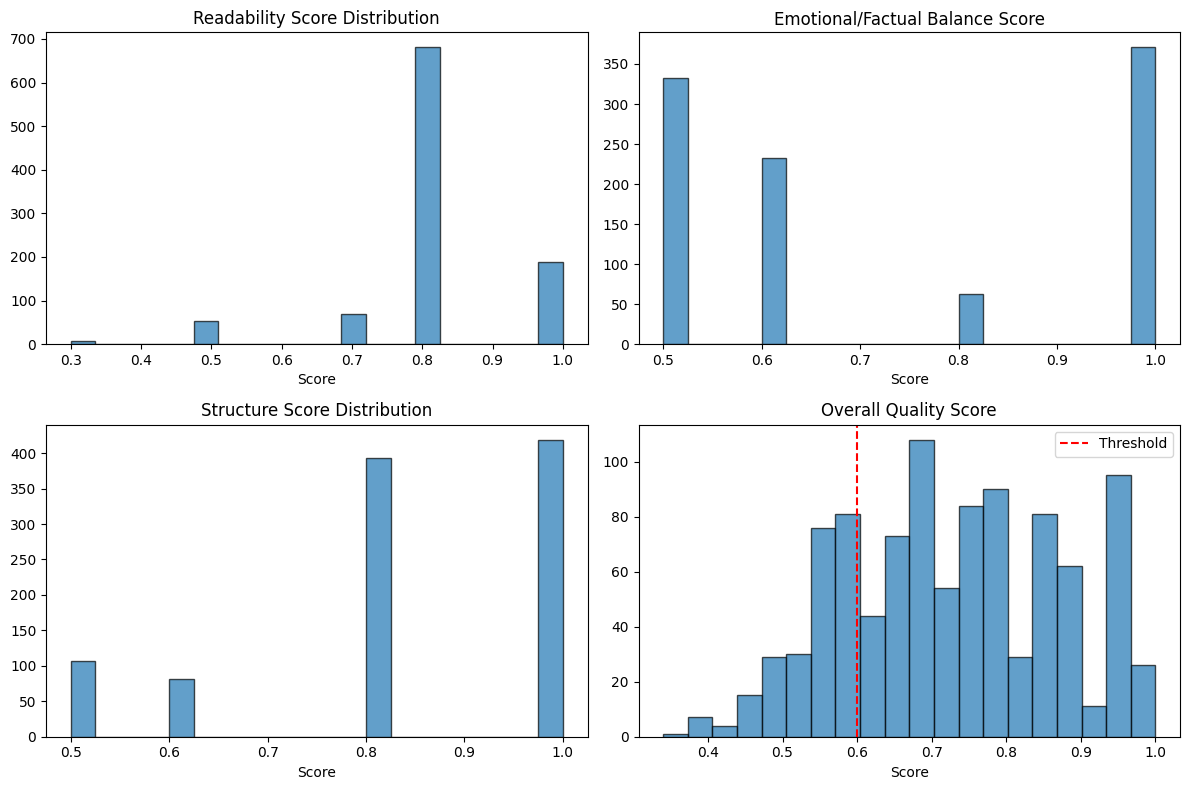

In [25]:
# Method 3: Content Quality Analysis

def calculate_quality_score(text):
    """Calculate informativeness score based on content quality"""
    
    # Readability score (Flesch Reading Ease)
    try:
        reading_ease = flesch_reading_ease(text)
        # Optimal readability range: 60-70 (standard)
        if reading_ease < 30:
            readability_score = 0.3  # Too difficult
        elif reading_ease < 60:
            readability_score = 0.7  # Somewhat difficult
        elif reading_ease <= 70:
            readability_score = 1.0  # Good readability
        elif reading_ease <= 90:
            readability_score = 0.8  # Easy to read
        else:
            readability_score = 0.5  # Too simple
    except:
        readability_score = 0.5  # Default if calculation fails
    
    text_lower = text.lower()
    
    # Emotional vs factual content
    emotional_words = ['love', 'hate', 'amazing', 'terrible', 'awesome', 'awful', 'fantastic', 
                      'horrible', 'wonderful', 'disgusting', 'perfect', 'worst', 'best']
    factual_words = ['because', 'since', 'due to', 'reason', 'caused', 'result', 'therefore',
                    'however', 'although', 'despite', 'while', 'whereas', 'specifically']
    
    emotional_count = sum(1 for word in emotional_words if word in text_lower)
    factual_count = sum(1 for word in factual_words if word in text_lower)
    
    total_indicators = emotional_count + factual_count
    if total_indicators == 0:
        balance_score = 0.5
    else:
        # Better balance = more informative (slight preference for factual)
        factual_ratio = factual_count / total_indicators
        if factual_ratio >= 0.4:  # Good balance or more factual
            balance_score = 1.0
        elif factual_ratio >= 0.2:
            balance_score = 0.8
        else:
            balance_score = 0.6  # Too emotional
    
    # Grammar and structure indicators
    question_marks = text.count('?')
    exclamation_marks = text.count('!')
    punctuation_variety = len(set([c for c in text if c in '.,!?;:']))
    
    # Moderate punctuation use indicates better structure
    if exclamation_marks > 3:
        structure_score = 0.6  # Too many exclamations
    elif punctuation_variety >= 3:
        structure_score = 1.0  # Good variety
    elif punctuation_variety >= 2:
        structure_score = 0.8  # Decent
    else:
        structure_score = 0.5  # Limited structure
    
    # Actionable insights indicators
    actionable_words = ['recommend', 'suggest', 'avoid', 'try', 'should', 'would', 'will',
                       'go back', 'return', 'visit', 'skip', 'worth', 'not worth']
    actionable_count = sum(1 for word in actionable_words if word in text_lower)
    actionable_score = min(actionable_count / 2, 1.0)
    
    # Combined quality score
    quality_score = (readability_score * 0.3 + balance_score * 0.3 + 
                    structure_score * 0.2 + actionable_score * 0.2)
    
    return {
        'readability_score': readability_score,
        'balance_score': balance_score,
        'structure_score': structure_score,
        'actionable_score': actionable_score,
        'quality_score': quality_score
    }

# Calculate quality scores
quality_features = df['cleaned_text'].apply(calculate_quality_score)
quality_df = pd.DataFrame(quality_features.tolist())

# Add to main dataframe
df = pd.concat([df, quality_df], axis=1)

# Classify reviews based on quality score
df['quality_informative'] = df['quality_score'] >= 0.6

print("Content Quality Analysis Results:")
print(f"Reviews classified as informative (quality): {df['quality_informative'].sum()}/{len(df)} ({df['quality_informative'].mean():.1%})")
print(f"Average quality score: {df['quality_score'].mean():.3f}")

print("\nAverage component scores:")
print(f"Readability: {df['readability_score'].mean():.3f}")
print(f"Emotional/Factual balance: {df['balance_score'].mean():.3f}")
print(f"Structure: {df['structure_score'].mean():.3f}")
print(f"Actionable insights: {df['actionable_score'].mean():.3f}")

# Visualize quality components
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].hist(df['readability_score'], bins=20, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Readability Score Distribution')
axes[0,0].set_xlabel('Score')

axes[0,1].hist(df['balance_score'], bins=20, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Emotional/Factual Balance Score')
axes[0,1].set_xlabel('Score')

axes[1,0].hist(df['structure_score'], bins=20, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Structure Score Distribution')
axes[1,0].set_xlabel('Score')

axes[1,1].hist(df['quality_score'], bins=20, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Overall Quality Score')
axes[1,1].set_xlabel('Score')
axes[1,1].axvline(x=0.6, color='red', linestyle='--', label='Threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## Combined Informativeness Score

Now let's combine all three methods to create a comprehensive informativeness score.

Combined Analysis Results:
Reviews classified as informative (combined): 708/1000 (70.8%)
Average combined score: 0.670

Method Comparison (% classified as informative):
Length Method: 94.5%
Specificity Method: 48.2%
Quality Method: 76.0%
Combined Method: 70.8%


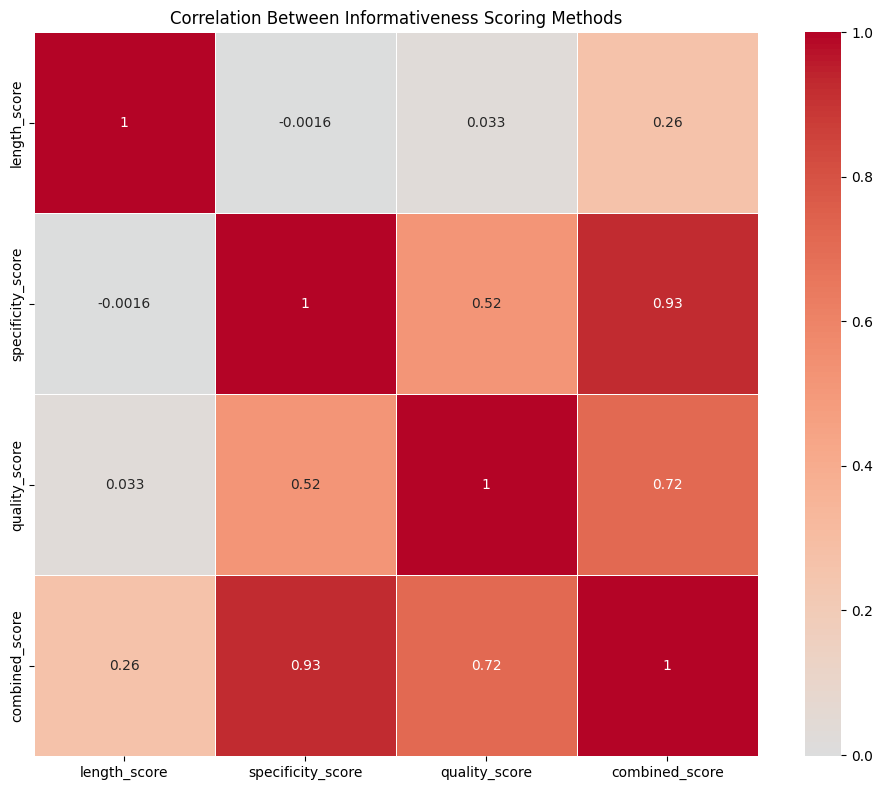

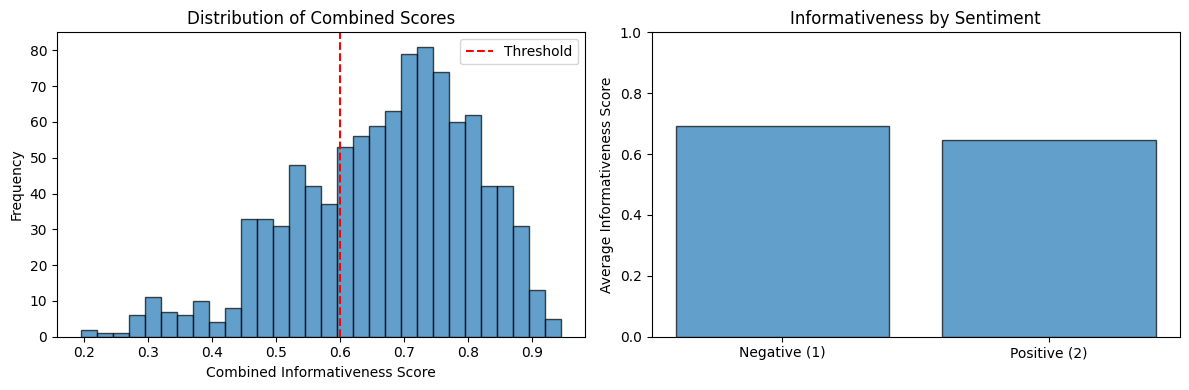

In [26]:
# Combined Informativeness Score

# Calculate combined score using weighted average
df['combined_score'] = (df['length_score'] * 0.3 + 
                       df['specificity_score'] * 0.4 + 
                       df['quality_score'] * 0.3)

# Final classification
df['is_informative'] = df['combined_score'] >= 0.6

print("Combined Analysis Results:")
print(f"Reviews classified as informative (combined): {df['is_informative'].sum()}/{len(df)} ({df['is_informative'].mean():.1%})")
print(f"Average combined score: {df['combined_score'].mean():.3f}")

# Compare all methods
method_comparison = pd.DataFrame({
    'Length Method': [df['length_informative'].mean()],
    'Specificity Method': [df['specificity_informative'].mean()],
    'Quality Method': [df['quality_informative'].mean()],
    'Combined Method': [df['is_informative'].mean()]
})

print(f"\nMethod Comparison (% classified as informative):")
for method, percentage in method_comparison.iloc[0].items():
    print(f"{method}: {percentage:.1%}")

# Correlation between methods
correlation_matrix = df[['length_score', 'specificity_score', 'quality_score', 'combined_score']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Between Informativeness Scoring Methods')
plt.tight_layout()
plt.show()

# Distribution of combined scores
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['combined_score'], bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=0.6, color='red', linestyle='--', label='Threshold')
plt.xlabel('Combined Informativeness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Combined Scores')
plt.legend()

plt.subplot(1, 2, 2)
scores_by_sentiment = df.groupby('class_index')['combined_score'].mean()
plt.bar(['Negative (1)', 'Positive (2)'], scores_by_sentiment.values, alpha=0.7, edgecolor='black')
plt.ylabel('Average Informativeness Score')
plt.title('Informativeness by Sentiment')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [27]:
# Examples of Most and Least Informative Reviews

print("=== TOP 3 MOST INFORMATIVE REVIEWS ===\n")
most_informative = df.nlargest(3, 'combined_score')

for i, (idx, row) in enumerate(most_informative.iterrows(), 1):
    print(f"Review {i} (Score: {row['combined_score']:.3f}):")
    print(f"Length: {row['word_count']} words, {row['sentence_count']} sentences")
    print(f"Scores - Length: {row['length_score']:.2f}, Specificity: {row['specificity_score']:.2f}, Quality: {row['quality_score']:.2f}")
    print(f"Text: {row['review_text'][:300]}{'...' if len(row['review_text']) > 300 else ''}")
    print("-" * 80)

print("\n=== TOP 3 LEAST INFORMATIVE REVIEWS ===\n")
least_informative = df.nsmallest(3, 'combined_score')

for i, (idx, row) in enumerate(least_informative.iterrows(), 1):
    print(f"Review {i} (Score: {row['combined_score']:.3f}):")
    print(f"Length: {row['word_count']} words, {row['sentence_count']} sentences")
    print(f"Scores - Length: {row['length_score']:.2f}, Specificity: {row['specificity_score']:.2f}, Quality: {row['quality_score']:.2f}")
    print(f"Text: {row['review_text'][:300]}{'...' if len(row['review_text']) > 300 else ''}")
    print("-" * 80)

=== TOP 3 MOST INFORMATIVE REVIEWS ===

Review 1 (Score: 0.946):
Length: 352 words, 25 sentences
Scores - Length: 0.82, Specificity: 1.00, Quality: 1.00
Text: I've hesitated to write about Fate. I always enjoyed the food and experience at the owner's old Lucky Dragon, even back when it was on University. I also appreciate the fact that Fate is a downtown pioneer, and that one can eat there after 9:00.\n\nWe've been to Fate a number of times, with vaguely ...
--------------------------------------------------------------------------------
Review 2 (Score: 0.943):
Length: 143 words, 11 sentences
Scores - Length: 0.90, Specificity: 1.00, Quality: 0.91
Text: My family visited the restaurant recently. There was a dispute about the bill and the manager was called in at the request of my family. The manager was not only not nice but very unprofessional. We are hard working people. We expect good service because we pay for what we order and also tip accordi...
---------------------------------

## Practical Application: Review Informativeness Classifier

Let's create a simple function that you can use to classify any new review as informative or not.

In [28]:
def classify_review_informativeness(review_text, threshold=0.6, return_details=False):
    """
    Classify a review as informative or not based on our multi-method approach.
    
    Parameters:
    review_text (str): The review text to analyze
    threshold (float): Threshold for classification (default: 0.6)
    return_details (bool): Whether to return detailed scores
    
    Returns:
    bool or dict: True/False for informativeness, or detailed scores if return_details=True
    """
    
    # Clean text
    cleaned = clean_text(review_text)
    
    # Extract basic features
    basic_feat = extract_basic_features(cleaned)
    
    # Calculate scores
    length_score = calculate_length_score(pd.Series(basic_feat))
    specificity_scores = calculate_specificity_score(cleaned)
    quality_scores = calculate_quality_score(cleaned)
    
    # Combined score
    combined_score = (length_score * 0.3 + 
                     specificity_scores['specificity_score'] * 0.4 + 
                     quality_scores['quality_score'] * 0.3)
    
    is_informative = combined_score >= threshold
    
    if return_details:
        return {
            'is_informative': is_informative,
            'combined_score': combined_score,
            'length_score': length_score,
            'specificity_score': specificity_scores['specificity_score'],
            'quality_score': quality_scores['quality_score'],
            'word_count': basic_feat['word_count'],
            'sentence_count': basic_feat['sentence_count'],
            'details': {
                'length_breakdown': basic_feat,
                'specificity_breakdown': specificity_scores,
                'quality_breakdown': quality_scores
            }
        }
    else:
        return is_informative

# Test the function with sample reviews
test_reviews = [
    "Great food!",  # Short, not informative
    "The service was excellent and the staff was very friendly. The atmosphere was cozy and the food was delicious. I especially enjoyed the pasta dish which was perfectly cooked. The prices were reasonable for the quality. I would definitely recommend this restaurant to others.",  # Should be informative
    "Terrible experience. Worst place ever.",  # Short, emotional, not informative
    "I visited last Tuesday around 7 PM. The wait time was about 15 minutes which was reasonable. Our server, Mike, was attentive and knowledgeable about the menu. I ordered the salmon dinner ($24) and my partner had the chicken special ($18). Both dishes were well-prepared and came with fresh vegetables. The portion sizes were generous. The only downside was the noise level - it was quite loud due to a large group nearby. Overall, good value for money and we'll likely return."  # Very informative
]

print("Testing Review Informativeness Classifier:")
print("=" * 60)

for i, review in enumerate(test_reviews, 1):
    result = classify_review_informativeness(review, return_details=True)
    print(f"\nReview {i}:")
    print(f"Text: \"{review[:100]}{'...' if len(review) > 100 else ''}\"")
    print(f"Informative: {result['is_informative']}")
    print(f"Combined Score: {result['combined_score']:.3f}")
    print(f"  - Length: {result['length_score']:.3f}")
    print(f"  - Specificity: {result['specificity_score']:.3f}")
    print(f"  - Quality: {result['quality_score']:.3f}")
    print(f"Word Count: {result['word_count']}, Sentences: {result['sentence_count']}")
    print("-" * 40)

Testing Review Informativeness Classifier:

Review 1:
Text: "Great food!"
Informative: False
Combined Score: 0.195
  - Length: 0.250
  - Specificity: 0.000
  - Quality: 0.400
Word Count: 2, Sentences: 1
----------------------------------------

Review 2:
Text: "The service was excellent and the staff was very friendly. The atmosphere was cozy and the food was ..."
Informative: True
Combined Score: 0.836
  - Length: 1.000
  - Specificity: 0.733
  - Quality: 0.810
Word Count: 44, Sentences: 5
----------------------------------------

Review 3:
Text: "Terrible experience. Worst place ever."
Informative: False
Combined Score: 0.321
  - Length: 0.370
  - Specificity: 0.247
  - Quality: 0.370
Word Count: 5, Sentences: 2
----------------------------------------

Review 4:
Text: "I visited last Tuesday around 7 PM. The wait time was about 15 minutes which was reasonable. Our ser..."
Informative: True
Combined Score: 0.917
  - Length: 0.940
  - Specificity: 0.867
  - Quality: 0.960
Word Count: 

## Summary and Key Insights

### Methods for Determining Review Informativeness:

1. **Length and Detail Analysis (30% weight)**
   - Optimal word count: 20-200 words
   - Multiple sentences preferred
   - Balanced sentence complexity

2. **Specificity Analysis (40% weight)**
   - Mentions specific business aspects (service, food, atmosphere, price, timing)
   - Uses descriptive adjectives
   - Includes concrete details (numbers, specific items, locations)
   - Contains comparative language

3. **Content Quality Analysis (30% weight)**
   - Good readability scores
   - Balance between emotional and factual content
   - Proper structure and grammar
   - Contains actionable insights

### Key Characteristics of Informative Reviews:

✅ **Informative Reviews Typically:**
- Have 30-150 words
- Mention specific aspects of the business
- Include descriptive details
- Provide actionable insights for other customers
- Balance emotion with facts
- Use varied vocabulary and sentence structure

❌ **Non-Informative Reviews Typically:**
- Are very short (< 10 words) or extremely long (> 300 words)
- Contain only general emotional statements
- Lack specific details about the experience
- Don't mention what others might find useful
- Are purely emotional without factual content

### Practical Applications:

1. **Business Owners**: Filter reviews to focus on actionable feedback
2. **Consumers**: Identify reviews that provide useful decision-making information
3. **Platforms**: Highlight or prioritize informative reviews
4. **Researchers**: Study patterns in customer feedback quality

### Recommendations for Writing Informative Reviews:

1. **Be Specific**: Mention what you ordered, when you visited, who served you
2. **Cover Multiple Aspects**: Service, food quality, atmosphere, value for money
3. **Include Details**: Prices, wait times, portion sizes, specific menu items
4. **Be Balanced**: Mention both positives and negatives
5. **Think of Future Customers**: What would they want to know?
6. **Use Descriptive Language**: Instead of "good," say "fresh and flavorful"

## Creating Informativeness Level Dataset

Now let's create a new dataset with reviews categorized by informativeness level on a 0-2 scale:
- **Level 0**: Least informative (combined_score < 0.4)
- **Level 1**: Moderately informative (0.4 ≤ combined_score < 0.7) 
- **Level 2**: Most informative (combined_score ≥ 0.7)

Informativeness Level Distribution:
Level 0 (Low     ):   44 reviews (  4.4%)
Level 1 (Moderate):  480 reviews ( 48.0%)
Level 2 (High    ):  476 reviews ( 47.6%)

Total reviews: 1000

SAMPLE REVIEWS BY INFORMATIVENESS LEVEL

🔍 LEVEL 0 - LOW INFORMATIVENESS
------------------------------------------------------------
Sample 1:
Score: 0.369 | Words: 14 | Sentences: 1
Text: got the buffet pizza was good they also give you free soup to .
----------------------------------------
Sample 2:
Score: 0.290 | Words: 6 | Sentences: 2
Text: a classic. nothing else to say
----------------------------------------

🔍 LEVEL 1 - MODERATE INFORMATIVENESS
------------------------------------------------------------
Sample 1:
Score: 0.652 | Words: 71 | Sentences: 7
Text: Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \"fixed\" it for free, and t...
-----------------------------------

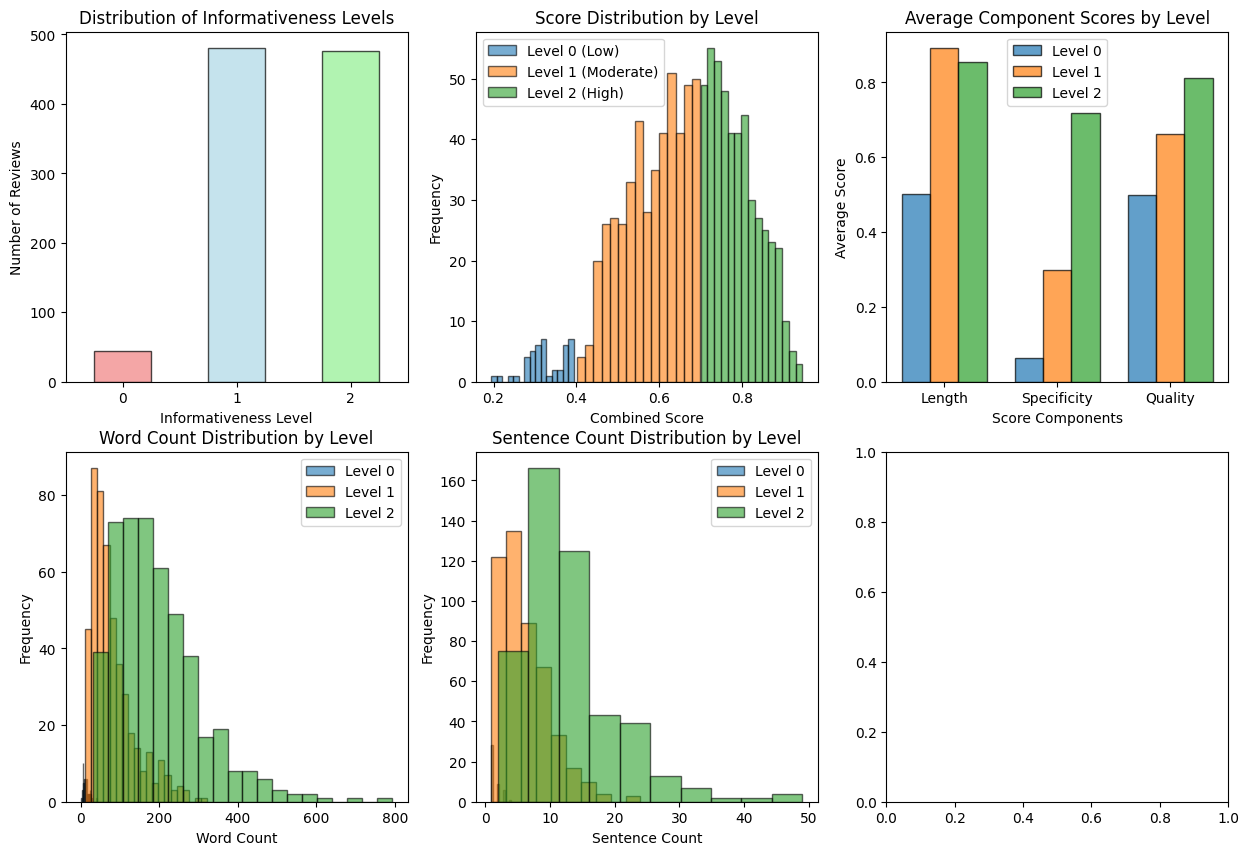

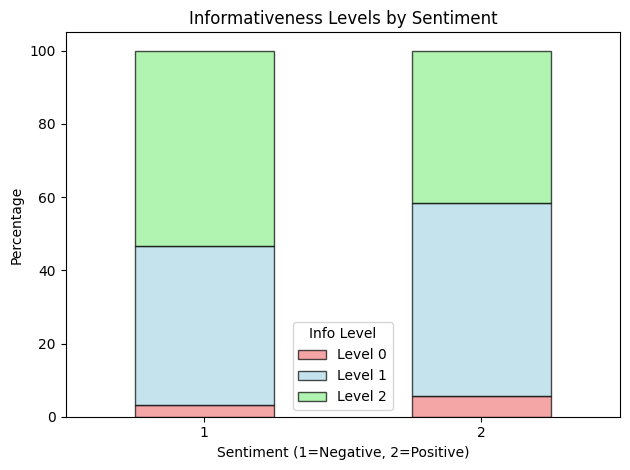


📊 Summary Statistics:
Average combined score by level:
  Level 0 (Low): 0.325
  Level 1 (Moderate): 0.585
  Level 2 (High): 0.787

Average word count by level:
  Level 0 (Low): 12.5 words
  Level 1 (Moderate): 80.2 words
  Level 2 (High): 193.3 words


In [29]:
# Create Informativeness Level Dataset

def assign_informativeness_level(combined_score):
    """
    Assign informativeness level based on combined score
    0: Least informative (score < 0.4)
    1: Moderately informative (0.4 ≤ score < 0.7)
    2: Most informative (score ≥ 0.7)
    """
    if combined_score < 0.4:
        return 0
    elif combined_score < 0.7:
        return 1
    else:
        return 2

# Apply informativeness level classification
df['informativeness_level'] = df['combined_score'].apply(assign_informativeness_level)

# Create the new dataset with selected columns
informativeness_dataset = df[['review_text', 'informativeness_level', 'combined_score', 
                             'length_score', 'specificity_score', 'quality_score',
                             'word_count', 'sentence_count', 'class_index']].copy()

# Add descriptive label for informativeness level
level_labels = {0: 'Low', 1: 'Moderate', 2: 'High'}
informativeness_dataset['informativeness_label'] = informativeness_dataset['informativeness_level'].map(level_labels)

print("Informativeness Level Distribution:")
print("=" * 50)
level_counts = informativeness_dataset['informativeness_level'].value_counts().sort_index()
for level, count in level_counts.items():
    label = level_labels[level]
    percentage = count / len(informativeness_dataset) * 100
    print(f"Level {level} ({label:<8}): {count:4d} reviews ({percentage:5.1f}%)")

print(f"\nTotal reviews: {len(informativeness_dataset)}")

# Display sample reviews from each level
print(f"\n" + "="*80)
print("SAMPLE REVIEWS BY INFORMATIVENESS LEVEL")
print("="*80)

for level in [0, 1, 2]:
    level_data = informativeness_dataset[informativeness_dataset['informativeness_level'] == level]
    label = level_labels[level]
    
    print(f"\n🔍 LEVEL {level} - {label.upper()} INFORMATIVENESS")
    print("-" * 60)
    
    # Get 2 sample reviews from this level
    samples = level_data.head(2)
    
    for idx, (_, row) in enumerate(samples.iterrows(), 1):
        print(f"Sample {idx}:")
        print(f"Score: {row['combined_score']:.3f} | Words: {row['word_count']} | Sentences: {row['sentence_count']}")
        print(f"Text: {row['review_text'][:200]}{'...' if len(row['review_text']) > 200 else ''}")
        print("-" * 40)

# Visualize the distribution
plt.figure(figsize=(15, 10))

# Plot 1: Level distribution
plt.subplot(2, 3, 1)
level_counts.plot(kind='bar', color=['lightcoral', 'lightblue', 'lightgreen'], alpha=0.7, edgecolor='black')
plt.xlabel('Informativeness Level')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Informativeness Levels')
plt.xticks(rotation=0)

# Plot 2: Score distribution by level
plt.subplot(2, 3, 2)
for level in [0, 1, 2]:
    level_data = informativeness_dataset[informativeness_dataset['informativeness_level'] == level]
    plt.hist(level_data['combined_score'], bins=15, alpha=0.6, 
             label=f'Level {level} ({level_labels[level]})', edgecolor='black')
plt.xlabel('Combined Score')
plt.ylabel('Frequency')
plt.title('Score Distribution by Level')
plt.legend()

# Plot 3: Average component scores by level
plt.subplot(2, 3, 3)
score_components = ['length_score', 'specificity_score', 'quality_score']
level_avg_scores = informativeness_dataset.groupby('informativeness_level')[score_components].mean()

x = np.arange(len(score_components))
width = 0.25

for i, level in enumerate([0, 1, 2]):
    plt.bar(x + i*width, level_avg_scores.loc[level], width, 
            label=f'Level {level}', alpha=0.7, edgecolor='black')

plt.xlabel('Score Components')
plt.ylabel('Average Score')
plt.title('Average Component Scores by Level')
plt.xticks(x + width, ['Length', 'Specificity', 'Quality'])
plt.legend()

# Plot 4: Word count distribution by level
plt.subplot(2, 3, 4)
for level in [0, 1, 2]:
    level_data = informativeness_dataset[informativeness_dataset['informativeness_level'] == level]
    plt.hist(level_data['word_count'], bins=20, alpha=0.6, 
             label=f'Level {level}', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution by Level')
plt.legend()

# Plot 5: Sentence count distribution by level
plt.subplot(2, 3, 5)
for level in [0, 1, 2]:
    level_data = informativeness_dataset[informativeness_dataset['informativeness_level'] == level]
    plt.hist(level_data['sentence_count'], bins=10, alpha=0.6, 
             label=f'Level {level}', edgecolor='black')
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.title('Sentence Count Distribution by Level')
plt.legend()

# Plot 6: Informativeness by sentiment
plt.subplot(2, 3, 6)
sentiment_info = informativeness_dataset.groupby(['class_index', 'informativeness_level']).size().unstack(fill_value=0)
sentiment_info_pct = sentiment_info.div(sentiment_info.sum(axis=1), axis=0) * 100

sentiment_info_pct.plot(kind='bar', stacked=True, 
                       color=['lightcoral', 'lightblue', 'lightgreen'], 
                       alpha=0.7, edgecolor='black')
plt.xlabel('Sentiment (1=Negative, 2=Positive)')
plt.ylabel('Percentage')
plt.title('Informativeness Levels by Sentiment')
plt.xticks(rotation=0)
plt.legend(title='Info Level', labels=['Level 0', 'Level 1', 'Level 2'])

plt.tight_layout()
plt.show()

print(f"\n📊 Summary Statistics:")
print(f"Average combined score by level:")
for level in [0, 1, 2]:
    level_data = informativeness_dataset[informativeness_dataset['informativeness_level'] == level]
    avg_score = level_data['combined_score'].mean()
    print(f"  Level {level} ({level_labels[level]}): {avg_score:.3f}")

print(f"\nAverage word count by level:")
for level in [0, 1, 2]:
    level_data = informativeness_dataset[informativeness_dataset['informativeness_level'] == level]
    avg_words = level_data['word_count'].mean()
    print(f"  Level {level} ({level_labels[level]}): {avg_words:.1f} words")

In [31]:
# Save the Informativeness Dataset to CSV

# Create a clean version for export
export_dataset = informativeness_dataset[[
    'review_text', 
    'informativeness_level', 
    'informativeness_label',
    'combined_score',
    'length_score',
    'specificity_score', 
    'quality_score',
    'word_count',
    'sentence_count',
    'class_index'
]].copy()

# Round scores for cleaner output
score_columns = ['combined_score', 'length_score', 'specificity_score', 'quality_score']
export_dataset[score_columns] = export_dataset[score_columns].round(3)

# Save to CSV
output_filename = 'dataset/test_informative.csv'
export_dataset.to_csv(output_filename, index=False, encoding='utf-8')

print(f"✅ Dataset saved successfully!")
print(f"📁 Filename: {output_filename}")
print(f"📊 Shape: {export_dataset.shape}")
print(f"💾 Size: {len(export_dataset)} reviews")

✅ Dataset saved successfully!
📁 Filename: dataset/test_informative.csv
📊 Shape: (1000, 10)
💾 Size: 1000 reviews


In [ ]:
# Updated Function to Classify Reviews with Informativeness Levels

def classify_review_with_level(review_text, return_details=False):
    """
    Classify a review and return informativeness level (0-2) and details.
    
    Parameters:
    review_text (str): The review text to analyze
    return_details (bool): Whether to return detailed breakdown
    
    Returns:
    dict: Contains informativeness_level, label, scores, and optionally detailed breakdown
    """
    
    # Use the existing classification function
    result = classify_review_informativeness(review_text, return_details=True)
    
    # Add informativeness level
    combined_score = result['combined_score']
    informativeness_level = assign_informativeness_level(combined_score)
    level_labels = {0: 'Low', 1: 'Moderate', 2: 'High'}
    
    # Create output
    output = {
        'informativeness_level': informativeness_level,
        'informativeness_label': level_labels[informativeness_level],
        'combined_score': combined_score,
        'is_informative': result['is_informative'],
        'length_score': result['length_score'],
        'specificity_score': result['specificity_score'],
        'quality_score': result['quality_score'],
        'word_count': result['word_count'],
        'sentence_count': result['sentence_count']
    }
    
    if return_details:
        output['details'] = result['details']
    
    return output

# Test the updated function
test_reviews_levels = [
    "Great!",  # Should be Level 0 (Low)
    "The food was good and service was okay. Nice atmosphere.",  # Should be Level 1 (Moderate)
    "I visited last Tuesday around 7 PM. The wait time was about 15 minutes which was reasonable. Our server, Mike, was attentive and knowledgeable about the menu. I ordered the salmon dinner ($24) and my partner had the chicken special ($18). Both dishes were well-prepared and came with fresh vegetables. The portion sizes were generous. The only downside was the noise level - it was quite loud due to a large group nearby. Overall, good value for money and we'll likely return."  # Should be Level 2 (High)
]

print("Testing Updated Classification Function:")
print("=" * 70)

for i, review in enumerate(test_reviews_levels, 1):
    result = classify_review_with_level(review, return_details=False)
    
    print(f"\nReview {i}:")
    print(f"Text: \"{review[:80]}{'...' if len(review) > 80 else ''}\"")
    print(f"Informativeness Level: {result['informativeness_level']} ({result['informativeness_label']})")
    print(f"Combined Score: {result['combined_score']:.3f}")
    print(f"Component Scores - Length: {result['length_score']:.3f}, "
          f"Specificity: {result['specificity_score']:.3f}, Quality: {result['quality_score']:.3f}")
    print(f"Metrics: {result['word_count']} words, {result['sentence_count']} sentences")
    print("-" * 50)

print(f"\n🎯 The updated function now returns:")
print("✅ Informativeness level (0, 1, or 2)")
print("✅ Informativeness label (Low, Moderate, High)")
print("✅ All component scores and metrics")
print("✅ Backward compatibility with boolean is_informative")